### Draw with Pixel CNN

##### Introduction and Preprocessing

本节参考 [斗大的熊猫](http://blog.topspeedsnail.com/archives/10660) ，使用 Pixel 在 MNIST 数据集上进行 CNN 学习和生成

代码参考

- [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)
- [Pixel Recurrent Neural Networks](https://arxiv.org/abs/1601.06759)
- [Draw](https://github.com/ericjang/draw)
- [image analogies](https://github.com/awentzonline/image-analogies)

代码只实现了unconditional模型（无条件），没有实现conditional和autoencoder模型。详细信息，请参看参考 1 论文。

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'0.9.0'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets('data/MNIST/')    # 这里 one_hot 为 False，就是说标签读取为 1 个标量 (0 ~ 9)，而不是 one-hot 的 10 维矢量
image_height = 28
image_width = 28
image_channel = 1
 
batch_size = 128
n_batches = data.train.num_examples // batch_size
print(u"图像总数: ", data.train.num_examples)
print(u"batch 总数: ", n_batches)           # 每个 batch， X 的 shape 为 batch_size * 784 ，而 Y 的 shape 为 batch_size 

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
(u'\u56fe\u50cf\u603b\u6570: ', 55000)
(u'batch \u603b\u6570: ', 429)


In [4]:
X = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_channel])
 
def gated_cnn(W_shape_, fan_in, gated=True, payload=None, mask=None, activation=True):
    """ 
        W_shape_ 为  filter_size * filter_size * num_filters 
        fan_in 是输入 input，为 batch_size * height * width * num_channels
    """
    # 定义 W 和 b 的 shape
    # W 为 filter_size * filter_size * num_channels * num_filters，即正常 CNN 的 Weight
    W_shape = [W_shape_[0], W_shape_[1], fan_in.get_shape()[-1], W_shape_[2]]    
    # b 为 num_filters ，每个 filter 对应同一个 b
    b_shape = W_shape_[2]
 
    def get_weights(shape, name, mask=None):
        """
        使用 xavier_initializer 初始化 4 维权重变量
        如果定义了了 mask，则让某些权重置为 0
        """
        weights_initializer = tf.contrib.layers.xavier_initializer()
        W = tf.get_variable(name, shape, tf.float32, weights_initializer)
 
        if mask:
            filter_mid_x = shape[0] // 2
            filter_mid_y = shape[1] // 2
            mask_filter = np.ones(shape, dtype=np.float32)
            mask_filter[filter_mid_x, filter_mid_y + 1:, :, :] = 0.
            mask_filter[filter_mid_x + 1:, :, :, :] = 0.
 
            if mask == 'a':
                mask_filter[filter_mid_x, filter_mid_y, :, :] = 0.
 
            W *= mask_filter 
        return W
 
    if gated:
        W_f = get_weights(W_shape, "v_W", mask=mask)    # vertical 
        W_g = get_weights(W_shape, "h_W", mask=mask)    # horizontal
 
        b_f = tf.get_variable("v_b", b_shape, tf.float32, tf.zeros_initializer)
        b_g = tf.get_variable("h_b", b_shape, tf.float32, tf.zeros_initializer)
 
        # 在 vertical 和 horizontal 上各做一次 CNN
        # CNN 不会调整输出的尺寸，因为不做 pooling，而且 padding='SAME'，strides = 1
        conv_f = tf.nn.conv2d(fan_in, W_f, strides=[1,1,1,1], padding='SAME')
        conv_g = tf.nn.conv2d(fan_in, W_g, strides=[1,1,1,1], padding='SAME')
        
        if payload is not None:
            conv_f += payload
            conv_g += payload
 
        # 整合为一个结果，输出
        fan_out = tf.mul(tf.tanh(conv_f + b_f), tf.sigmoid(conv_g + b_g))
    # 如果不是 gated，那么简单了，就是普通的 CNN
    else:
        W = get_weights(W_shape, "W", mask=mask)
        b = tf.get_variable("b", b_shape, tf.float32, tf.zeros_initializer)
        conv = tf.nn.conv2d(fan_in, W, strides=[1,1,1,1], padding='SAME')
        if activation: 
            fan_out = tf.nn.relu(tf.add(conv, b))
        else:
            fan_out = tf.add(conv, b)
 
    return fan_out

 
def pixel_cnn(layers=12, f_map=32, reuse=False):
    """ f_map 为每层 CNN 中 filters 的个数 """
    v_stack_in, h_stack_in = X, X    # 都是 X, batch_size * height * width * num_channels
 
    for i in range(layers):
        # 第一层和后面的层有着不同的属性
        filter_size = 3 if i > 0 else 7
        mask = 'b' if i > 0 else 'a'
        residual = True if i > 0 else False
        i = str(i)
 
        # 这里做 gate cnn
        with tf.variable_scope("v_stack" + i, reuse=reuse):
            v_stack = gated_cnn([filter_size, filter_size, f_map], v_stack_in, mask=mask)
            v_stack_in = v_stack
 
        # 这里做普通 cnn, filter_size 1 * 1，故此为 pixel cnn
        with tf.variable_scope("v_stack_1" + i, reuse=reuse):
            v_stack_1 = gated_cnn([1, 1, f_map], v_stack_in, gated=False, mask=mask)
 
        # 注意，v_stack_1 以 payload 形式加入 h 方向的 cnn 计算
        # 这里做 gate cnn
        with tf.variable_scope("h_stack" + i, reuse=reuse):
            h_stack = gated_cnn([1, filter_size, f_map], h_stack_in, payload=v_stack_1, mask=mask)
 
        # 这里做普通 cnn
        with tf.variable_scope("h_stack_1" + i, reuse=reuse):
            h_stack_1 = gated_cnn([1, 1, f_map], h_stack, gated=False, mask=mask)
            if residual:
                h_stack_1 += h_stack_in
            h_stack_in = h_stack_1
 
    # 这里做普通 cnn
    with tf.variable_scope("fc_1", reuse=reuse):
        fc1 = gated_cnn([1, 1, f_map], h_stack_in, gated=False, mask='b')
 
    color = 256
    # 这里做普通 cnn
    with tf.variable_scope("fc_2", reuse=reuse):
        fc2 = gated_cnn([1, 1, image_channel * color], fc1, gated=False, mask='b', activation=False)
        # 最后，把全部 batch 的结果展开
        fc2 = tf.reshape(fc2, (-1, color))

    return fc2

 
def train_pixel_cnn():
    output = pixel_cnn()
 
    # 使用 output 出来的结果和 X 本身做比较，类似 Auto-encoder，希望和本身尽量相似；
    # 注意，把 X 进行了一维化，故此结果 output 也是一维的
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(output, tf.cast(tf.reshape(X, [-1]), dtype=tf.int32)))
    trainer = tf.train.RMSPropOptimizer(1e-3)
    gradients = trainer.compute_gradients(loss)
    clipped_gradients = [(tf.clip_by_value(_[0], -1, 1), _[1]) for _ in gradients]
    optimizer = trainer.apply_gradients(clipped_gradients)
 
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        saver = tf.train.Saver(tf.trainable_variables())
 
        for epoch in range(50):   
            for batch in range(n_batches):
                # batch_X 为 batch_size * 784 ；另外，这里并不需要 batch_Y
                batch_X, _ = data.train.next_batch(batch_size)
                # 转为 batch_size * 28 * 28 * 1
                batch_X = batch_X.reshape([batch_size, image_height, image_width, image_channel])
 
                _, cost = sess.run([optimizer, loss], feed_dict={X:batch_X})
                print("epoch:", epoch, '  batch:', batch,'  cost:', cost)
            if epoch % 10 == 0:
                saver.save(sess, "pixel_mnist.ckpt", global_step=epoch)

In [ ]:
train_pixel_cnn()

('epoch:', 0, '  batch:', 0, '  cost:', 5.544889)
('epoch:', 0, '  batch:', 1, '  cost:', 5.5430598)
('epoch:', 0, '  batch:', 2, '  cost:', 5.5399408)
('epoch:', 0, '  batch:', 3, '  cost:', 5.5377617)
('epoch:', 0, '  batch:', 4, '  cost:', 5.5354877)
('epoch:', 0, '  batch:', 5, '  cost:', 5.532001)
('epoch:', 0, '  batch:', 6, '  cost:', 5.5303993)
('epoch:', 0, '  batch:', 7, '  cost:', 5.5275893)
('epoch:', 0, '  batch:', 8, '  cost:', 5.5236111)
('epoch:', 0, '  batch:', 9, '  cost:', 5.5208211)
('epoch:', 0, '  batch:', 10, '  cost:', 5.5166974)
('epoch:', 0, '  batch:', 11, '  cost:', 5.5145674)
('epoch:', 0, '  batch:', 12, '  cost:', 5.5098472)
('epoch:', 0, '  batch:', 13, '  cost:', 5.5068445)
('epoch:', 0, '  batch:', 14, '  cost:', 5.5017676)
('epoch:', 0, '  batch:', 15, '  cost:', 5.4990296)
('epoch:', 0, '  batch:', 16, '  cost:', 5.4934249)
('epoch:', 0, '  batch:', 17, '  cost:', 5.4897051)
('epoch:', 0, '  batch:', 18, '  cost:', 5.4845853)
('epoch:', 0, '  batch:'

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
def generate_by_pixel(module_file):
    output = pixel_cnn(reuse=True)
 
    predict = tf.reshape(tf.multinomial(tf.nn.softmax(output), num_samples=1, seed=100), tf.shape(X))
    print predict.get_shape()
 
    with tf.Session() as sess: 
        sess.run(tf.initialize_all_variables())
 
        saver = tf.train.Saver(tf.trainable_variables())
        saver.restore(sess, module_file)
 
        # batch_size 1*1 = 1
        pics = np.zeros((1*1, image_height, image_width, image_channel), dtype=np.float32)
 
        for i in range(image_height):
            for j in range(image_width):
                for k in range(image_channel):
                    next_pic = sess.run(predict, feed_dict={X:pics})
                    # 每次从 run 出来的 predict 图像中取出对应的一个 pixel
                    pics[:, i, j, k] = next_pic[:, i, j, k]
         
        print pics[0].shape    # 28 * 28 * 1
        # 如果画 3 维的矢量，那么 plt.imshow 需要第三维为 3 或 4
        # 这里是灰度图，故此只有两维即可，第三维是 1，需要去掉
        plt.imshow(np.float32(pics[0].reshape(image_height, image_width)), interpolation='lanczos')
        print('generate: pixel_generated.jpg')
        


(?, ?, ?, ?)
(28, 28, 1)
generate: pixel_generated.jpg


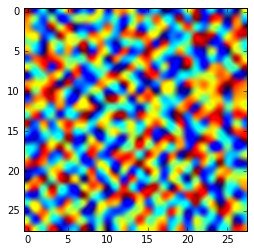

In [46]:
generate_by_pixel('pixel_mnist.ckpt-0')

(?, ?, ?, ?)
(28, 28, 1)
generate: pixel_generated.jpg


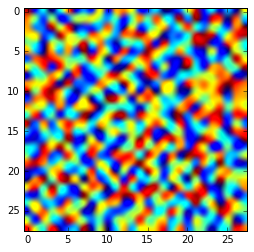

In [13]:
generate_by_pixel('pixel_mnist.ckpt-20')

(?, ?, ?, ?)
(28, 28, 1)
generate: pixel_generated.jpg


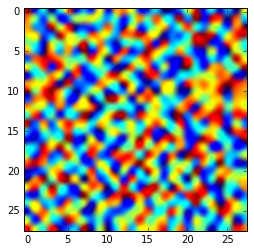

In [15]:
generate_by_pixel('pixel_mnist.ckpt-40')

In [ ]:
def pixel_cnn_single_color(layers=12, f_map=32, reuse=False):
    """ f_map 为每层 CNN 中 filters 的个数 """
    v_stack_in, h_stack_in = X, X    # 都是 X, batch_size * height * width * num_channels
 
    for i in range(layers):
        # 第一层和后面的层有着不同的属性
        filter_size = 3 if i > 0 else 7
        mask = 'b' if i > 0 else 'a'
        residual = True if i > 0 else False
        i = str(i)
 
        # 这里做 gate cnn
        with tf.variable_scope("v_stack" + i, reuse=reuse):
            v_stack = gated_cnn([filter_size, filter_size, f_map], v_stack_in, mask=mask)
            v_stack_in = v_stack
 
        # 这里做普通 cnn, filter_size 1 * 1，故此为 pixel cnn
        with tf.variable_scope("v_stack_1" + i, reuse=reuse):
            v_stack_1 = gated_cnn([1, 1, f_map], v_stack_in, gated=False, mask=mask)
 
        # 注意，v_stack_1 以 payload 形式加入 h 方向的 cnn 计算
        # 这里做 gate cnn
        with tf.variable_scope("h_stack" + i, reuse=reuse):
            h_stack = gated_cnn([1, filter_size, f_map], h_stack_in, payload=v_stack_1, mask=mask)
 
        # 这里做普通 cnn
        with tf.variable_scope("h_stack_1" + i, reuse=reuse):
            h_stack_1 = gated_cnn([1, 1, f_map], h_stack, gated=False, mask=mask)
            if residual:
                h_stack_1 += h_stack_in
            h_stack_in = h_stack_1
 
    # 这里做普通 cnn
    with tf.variable_scope("fc_1", reuse=reuse):
        fc1 = gated_cnn([1, 1, f_map], h_stack_in, gated=False, mask='b')
 
    color = 1
    # 这里做普通 cnn
    with tf.variable_scope("fc_2", reuse=reuse):
        fc2 = gated_cnn([1, 1, image_channel * color], fc1, gated=False, mask='b', activation=False)
        # 最后，把全部 batch 的结果展开
        fc2 = tf.reshape(fc2, (-1, color))

    return fc2


output = pixel_cnn_single_color()
 
# 使用 output 出来的结果和 X 本身做比较，类似 Auto-encoder，希望和本身尽量相似；
# 注意，把 X 进行了一维化，故此结果 output 也是一维的
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(output, tf.cast(tf.reshape(X, [-1]), dtype=tf.int32)))
trainer = tf.train.RMSPropOptimizer(1e-3)
gradients = trainer.compute_gradients(loss)
clipped_gradients = [(tf.clip_by_value(_[0], -1, 1), _[1]) for _ in gradients]
optimizer = trainer.apply_gradients(clipped_gradients)
 
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver(tf.trainable_variables())
 
for epoch in range(20 + 1):   
    for batch in range(n_batches):
        # batch_X 为 batch_size * 784 ；另外，这里并不需要 batch_Y
        batch_X, _ = data.train.next_batch(batch_size)
        # 转为 batch_size * 28 * 28 * 1
        batch_X = batch_X.reshape([batch_size, image_height, image_width, image_channel])
 
        _, cost = sess.run([optimizer, loss], feed_dict={X:batch_X})
        print("epoch:", epoch, '  batch:', batch,'  cost:', cost)
    if epoch % 10 == 0:
        saver.save(sess, "pixel_mnist.ckpt", global_step=epoch)